In [2]:
import cv2 as cv
import tensorflow as tf
from tensorflow.keras import models,layers
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense,Conv2D,MaxPooling2D,Flatten,Dropout
import matplotlib.pyplot as plt
import os
import imghdr
import numpy as np
import random

#  I: Prepare Data

In [6]:
data_dir = 'Car-Bike-Dataset'
image_exts = ['jpeg','jpg','bmp','png']

In [7]:
name_dir = os.listdir(data_dir)
len_dir = [len(os.listdir(os.path.join(data_dir, i))) for i in name_dir]
print(len_dir)

[1998, 1983]


In [9]:
# xoa cac dinh dang anh khong phu hop
def remove_img(data_dir , image_exts):
    for img in os.listdir(data_dir):
        for image in os.listdir(os.path.join(data_dir , img)):
            image_path = os.path.join(data_dir , img , image)
            try:
                tip = imghdr.what(image_path)
                if tip not in image_exts:
                    print('Image not in ext {}'.format(image_path))
                    os.remove(image_path)
            except Exception as e:
                print('Issure not image {}'.format(image_path))
                os.remove(image_path)

In [10]:
remove_img(data_dir, image_exts)

In [11]:
len_dir_last = [len(os.listdir(os.path.join(data_dir, i))) for i in name_dir ]
print(len_dir_last)

[1998, 1983]


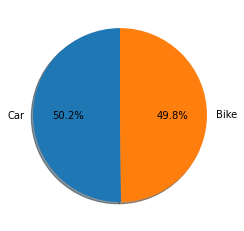

In [13]:
plt.pie(len_dir , labels = name_dir , autopct='%1.1f%%', startangle = 90, shadow = True)
plt.show()

In [14]:
IMAGE_SIZE = 60
BATCH_SIZE = 32 
CHANNELS = 3

In [16]:
Data = tf.keras.preprocessing.image_dataset_from_directory(
'Car-Bike-Dataset',
batch_size = 32,
image_size = (IMAGE_SIZE , IMAGE_SIZE),
shuffle = True
)

Found 3981 files belonging to 2 classes.


In [17]:
print('Number Batch : {}'.format(len(Data)))

Number Batch : 125


In [18]:
class_names = Data.class_names
len_class = len(Data.class_names)
print(class_names)
print(len_class)

['Bike', 'Car']
2


In [19]:
# 1 cho biet kich thuoc cua mot anh va so anh trong 1 bo
# cho thay duoc nhan 0 - 1 duoc gan vao anh
for image_batch, label_batch in Data.take(1):
    print(image_batch.shape)
    print(label_batch.numpy())

(32, 60, 60, 3)
[0 0 0 1 0 0 1 0 0 1 0 1 0 1 0 1 1 0 1 0 0 0 1 0 1 1 1 1 1 1 1 0]


In [20]:
# ham dung de show anh
def show_img(Data , number_img = [4,3]):
    plt.figure(figsize = (10 ,10))
    for image_batch, label_batch in Data.take(1):
        for i in range(number_img[0]*number_img[1]):
            ax = plt.subplot(number_img[0],number_img[1],i+1)
            plt.imshow(image_batch[i].numpy().astype('uint8'))
            plt.title(class_names[label_batch[i]]+' - label : {}'.format(label_batch[i].numpy()))
            plt.axis('off')

In [21]:
number_img = [4,3]
print(number_img[1]*number_img[0])
print(Data.take(1))

12
<TakeDataset element_spec=(TensorSpec(shape=(None, 60, 60, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>


In [22]:
figsize = (10 ,10)

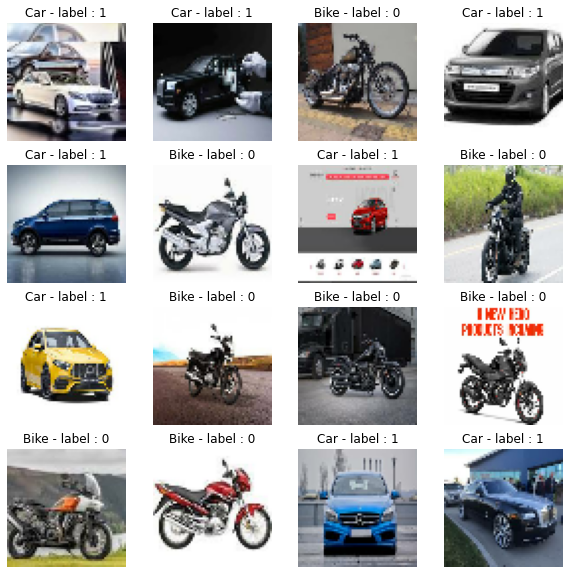

In [23]:
show_img(Data , [4,4])

In [24]:
# chia du lieu thanh 3 phan Train, Val , Test
def setting_data(data , train_scale = 0.8 , val_scale = 0.1, test_scale = 0.1,Shuffle = 1000):
    if Shuffle:
        data = data.shuffle(Shuffle,seed = 20)
    v_train = int(len(data)*0.8)
    v_val = int(len(data)*0.1)
    Train = data.take(v_train)
    Val = data.skip(v_train).take(v_val)
    Test = data.skip(v_train).skip(v_val)
    return Train, Val , Test

In [25]:
Train , Val , Test = setting_data(Data,Shuffle = 40)

In [26]:
print('Number Train : {}'.format(len(Train)))
print('Number Val : {}'.format(len(Val)))
print('Number Test : {}'.format(len(Test)))

Number Train : 100
Number Val : 12
Number Test : 13


In [27]:
Train = Train.cache().prefetch(buffer_size = tf.data.AUTOTUNE)
Val = Val.cache().prefetch(buffer_size = tf.data.AUTOTUNE)
Test = Test.cache().prefetch(buffer_size = tf.data.AUTOTUNE)

###https://www.tutorialspoint.com/how-can-tensorflow-be-used-to-configure-the-dataset-for-performance

# II: Build Model

In [28]:
def create_model(input_shape):
    rescale = tf.keras.Sequential([
    layers.experimental.preprocessing.Rescaling(1.0/255),
    layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE),])
    model = tf.keras.Sequential([
        rescale,
        #data_augmentation
        # Note the input shape is the desired size of the image 150x150 with 3 bytes color
        # This is the first convolution
        Conv2D(filters=32,kernel_size=(3,3), activation='relu', input_shape = input_shape),
        MaxPooling2D(pool_size=(2,2)),
        # The second convolution
        Conv2D(filters=32,kernel_size=(3,3), activation='relu'),
        MaxPooling2D(pool_size=(2,2)),
        Dropout(0.25),
        # The third convolution
        Conv2D(filters=64,kernel_size=(3,3), activation='relu'),
        MaxPooling2D(pool_size=(2,2)),
        Dropout(0.25),
        # Flatten the results to feed into a DNN
        Flatten(),
        # 128 neuron hidden layer
        Dense(128, activation='relu'),
        Dropout(0.25),
        Dense(1,  activation='sigmoid')
    ])
    model.compile(optimizer='adam',
                  loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
                  metrics=[tf.keras.metrics.BinaryAccuracy()])
    return model

In [29]:
input_shape = (BATCH_SIZE , IMAGE_SIZE , IMAGE_SIZE , CHANNELS)
model = create_model(input_shape)
model.build(input_shape = input_shape)

In [30]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (32, 60, 60, 3)           0         
                                                                 
 conv2d (Conv2D)             (32, 58, 58, 32)          896       
                                                                 
 max_pooling2d (MaxPooling2D  (32, 29, 29, 32)         0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (32, 27, 27, 32)          9248      
                                                                 
 max_pooling2d_1 (MaxPooling  (32, 13, 13, 32)         0         
 2D)                                                             
                                                                 
 dropout (Dropout)           (32, 13, 13, 32)         

In [31]:
checkpoint_path = "training_1/cp.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

In [35]:
# cp_callbac: train or save model 
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 verbose=1)
history = model.fit(Train,validation_data=Val, epochs=50 , batch_size = BATCH_SIZE,verbose = 1,callbacks=[cp_callback])

Epoch 1/50
100/100 [==============================] - ETA: 0s - loss: 0.2159 - binary_accuracy: 0.9056
Epoch 1: saving model to training_1/cp.ckpt
100/100 [==============================] - 24s 200ms/step - loss: 0.2159 - binary_accuracy: 0.9056 - val_loss: 0.2105 - val_binary_accuracy: 0.9193
Epoch 2/50
100/100 [==============================] - ETA: 0s - loss: 0.1858 - binary_accuracy: 0.9262
Epoch 2: saving model to training_1/cp.ckpt
100/100 [==============================] - 24s 200ms/step - loss: 0.1858 - binary_accuracy: 0.9262 - val_loss: 0.1588 - val_binary_accuracy: 0.9505
Epoch 3/50
100/100 [==============================] - ETA: 0s - loss: 0.1650 - binary_accuracy: 0.9331
Epoch 3: saving model to training_1/cp.ckpt
100/100 [==============================] - 24s 199ms/step - loss: 0.1650 - binary_accuracy: 0.9331 - val_loss: 0.1438 - val_binary_accuracy: 0.9427
Epoch 4/50
100/100 [==============================] - ETA: 0s - loss: 0.1598 - binary_accuracy: 0.9347
Epoch 4: sav

KeyboardInterrupt: 

In [32]:
history.history.keys()

##https://machinelearningmastery.com/display-deep-learning-model-training-history-in-keras/

NameError: name 'history' is not defined

In [31]:
plt.plot(history.history['loss'], color = 'orange',label= 'loss')
plt.plot(history.history['val_loss'], color = 'blue',label= 'val_loss')
plt.title('model loss',fontsize = 20)
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','test'],loc = 'upper left')
plt.show()

NameError: name 'history' is not defined

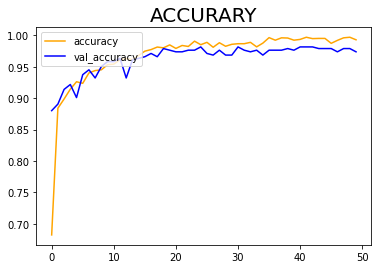

In [251]:
plt.plot(history.history['binary_accuracy'], color = 'orange',label= 'accuracy')
plt.plot(history.history['val_binary_accuracy'], color = 'blue',label= 'val_accuracy')
plt.title('model accuracy',fontsize = 20)
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [252]:
Test_model = model.evaluate(Test)

13/13 [==============================] - 27s 28ms/step - loss: 0.0509 - binary_accuracy: 0.9808


### Loading model

In [32]:
chack_path = 'training_1'

In [33]:
os.listdir(checkpoint_dir)

['cp.ckpt.data-00000-of-00001', 'checkpoint', 'cp.ckpt.index']

In [34]:
latest = tf.train.latest_checkpoint(checkpoint_dir)

In [35]:
new_model = create_model(input_shape)

In [36]:
new_model.load_weights(latest)

In [37]:
def test_img(model , test_ds , number = [3,3] , img_size = 60):
    list_name = os.listdir(test_ds)
    number_img = len(list_name)
    plt.figure(figsize = (15 ,15))
    for img in range(number[0]*number[1]):
        index_img = random.randint(0,number_img-1)
        name_img = list_name[index_img]
        path_img = os.path.join(test_ds , name_img)
        test_image2 = tf.keras.utils.load_img(path_img, target_size=(img_size,img_size))
        test_image2 = np.expand_dims(test_image2, axis=0)
        prediction = new_model.predict(test_image2)
        if prediction > 0.5:
            title = 'Car with accuracy {}'.format(prediction)
        else:
            title = 'Bike with accuracy {}'.format(1- prediction)
        
        plt.subplot(number[0], number[1], img+1)
        plt.imshow(test_image2[0])
        plt.axis('off')
        plt.title(title)

1/1 [==============================] - 0s 19ms/step


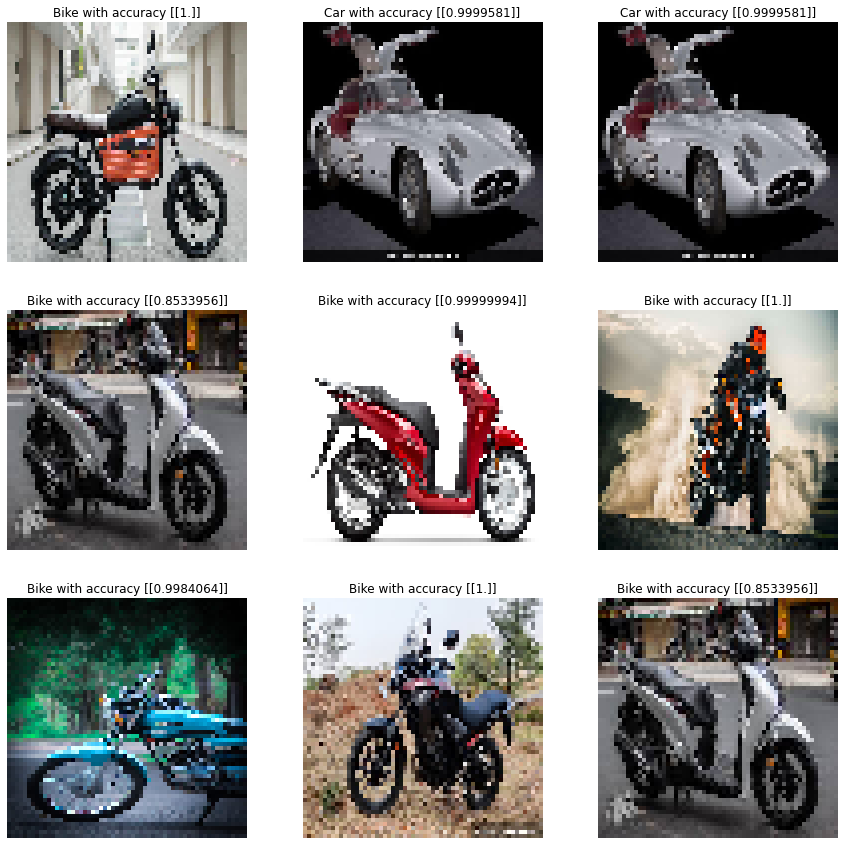

In [38]:
dir_test_model = 'Test'
test_img(new_model , dir_test_model , [3,3],60)